In [2]:
import numpy as np
import seaborn as sns
from keras import models, layers, callbacks, optimizers
from scipy.io import loadmat
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

ModuleNotFoundError: No module named 'keras'

In [2]:
train_mat = loadmat('data/train_32x32.mat')
test_mat = loadmat('data/test_32x32.mat')

#Format into np array of float pixels and 1d array of ints for labels
train_imgs = np.array(train_mat['X']).astype('float64')
train_lbls = np.array(train_mat['y']).flatten()
test_imgs = np.array(test_mat['X']).astype('float64')
test_lbls = np.array(test_mat['y']).flatten()

#Normalize to 0..1
train_imgs = train_imgs/255.0
test_imgs = test_imgs/255.0

In [3]:
train_imgs = np.moveaxis(train_imgs, -1, 0)
test_imgs = np.moveaxis(test_imgs, -1, 0)

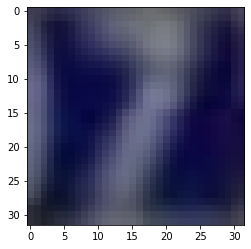

Label:  7


In [4]:
plt.imshow(train_imgs[2241])
plt.show()

print('Label: ', train_lbls[2241])

In [5]:
#Binarize labels
binarizer = LabelBinarizer()
train_lbls = binarizer.fit_transform(train_lbls)
test_lbls = binarizer.fit_transform(test_lbls)

In [6]:
X_trn, X_tst, y_trn, y_tst = train_test_split(train_imgs, train_lbls, test_size=0.2, random_state=3)
print(X_trn.shape, X_tst.shape, y_trn.shape, y_tst.shape)

(58605, 32, 32, 3) (14652, 32, 32, 3) (58605, 10) (14652, 10)


In [7]:
#CNN Model

model = models.Sequential(
    [
        layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', input_shape=(32, 32, 3)),
#        layers.BatchNormalization(),
#        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
#        layers.Dropout(0.1),
        layers.Conv2D(64, (3, 3), activation='relu'),
#        layers.BatchNormalization(),
#        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1)),
#        layers.Dropout(0.2),
        layers.Conv2D(128, (3, 3), activation='relu'),
#        layers.BatchNormalization(),
#        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1)),
#        layers.Dropout(0.3),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')        
    ]
)

In [8]:
#utility functions
optimizer = optimizers.Adam(lr=1e-3, amsgrad=True)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1)
red_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
checkpoint = callbacks.ModelCheckpoint('checkpoints/best.hdf5', save_best_only=True, verbose=1)

In [9]:
#Define parameters for applying random transformations to train data
train_datagen = ImageDataGenerator(
    rotation_range=8,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.95, 1.05],
)

#Generate batches of transformed image data
train_generator = train_datagen.flow(X_trn, y_trn, batch_size=250)

In [10]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(train_generator, epochs=100, validation_data=(X_tst, y_tst), callbacks=[early_stopping, red_lr, checkpoint])

Epoch 1/100
235/235 [==============================] - ETA: 0s - loss: 1.4359 - accuracy: 0.5208
Epoch 00001: val_loss improved from inf to 0.58681, saving model to checkpoints\best.hdf5
235/235 [==============================] - 993s 4s/step - loss: 1.4359 - accuracy: 0.5208 - val_loss: 0.5868 - val_accuracy: 0.8263
Epoch 2/100
235/235 [==============================] - ETA: 0s - loss: 0.8000 - accuracy: 0.7497
Epoch 00002: val_loss improved from 0.58681 to 0.45726, saving model to checkpoints\best.hdf5
235/235 [==============================] - 963s 4s/step - loss: 0.8000 - accuracy: 0.7497 - val_loss: 0.4573 - val_accuracy: 0.8649
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.7937
Epoch 00003: val_loss did not improve from 0.45726
235/235 [==============================] - 1027s 4s/step - loss: 0.6645 - accuracy: 0.7937 - val_loss: 0.4662 - val_accuracy: 0.8581
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 0.6087

Epoch 27/100
235/235 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.9028
Epoch 00027: val_loss did not improve from 0.26170
235/235 [==============================] - 745s 3s/step - loss: 0.3140 - accuracy: 0.9028 - val_loss: 0.2626 - val_accuracy: 0.9273
Epoch 28/100
235/235 [==============================] - ETA: 0s - loss: 0.3163 - accuracy: 0.9034
Epoch 00028: val_loss improved from 0.26170 to 0.25854, saving model to checkpoints\best.hdf5
235/235 [==============================] - 718s 3s/step - loss: 0.3163 - accuracy: 0.9034 - val_loss: 0.2585 - val_accuracy: 0.9278
Epoch 29/100
235/235 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.9025
Epoch 00029: val_loss did not improve from 0.25854
235/235 [==============================] - 707s 3s/step - loss: 0.3147 - accuracy: 0.9025 - val_loss: 0.2607 - val_accuracy: 0.9280
Epoch 30/100
235/235 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.9054
Epoch 00030: Red

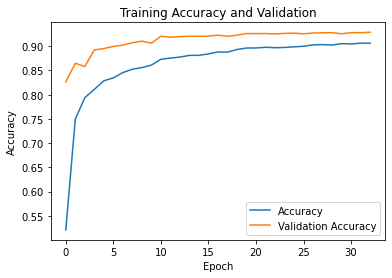

In [12]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy and Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

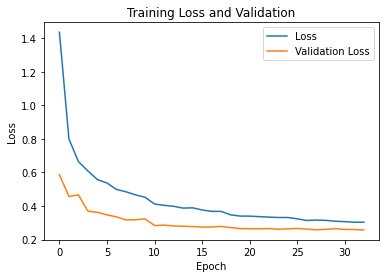

In [13]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [14]:
test_loss, test_accuracy = model.evaluate(test_imgs, test_lbls, verbose=1)
print('Accuracy: %s, Loss: %s' %(test_accuracy, test_loss))

814/814 [==============================] - 87s 106ms/step - loss: 0.2704 - accuracy: 0.9252
Accuracy: 0.9252074360847473, Loss: 0.2704070806503296


In [15]:
predictions = model.predict_classes(test_imgs)
test_labels = np.argmax(test_lbls, axis=1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [1]:
cm = confusion_matrix(test_labels, predictions)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cm, cmap='Reds', linewidth=0.5, linecolor='Black', annot=True, fmt="d").set(title="Validation Cofusion Matrix")

NameError: name 'confusion_matrix' is not defined